# ☘️ PLANT DISEASE CLASSIFICATION USING Custom CNN ☘️

# Description of the dataset 📝

# Our goal 🎯
Goal is clear and simple. We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.

##### Let's get started....

## Importing necessary libraries

Let's import required modules

We would require torchsummary library to print the model's summary in keras style (nicely formatted and pretty to look) as Pytorch natively doesn't support that

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary            

%matplotlib inline

# 🧭 Exploring the data 🧭

Loading the data 

In [25]:
DATA_DIR = "./new_data"
train_dir = DATA_DIR + "/train"
valid_dir = DATA_DIR + "/val"
test_dir = DATA_DIR + "/test"
diseases = os.listdir(train_dir)

In [26]:
# printing the disease names
print(diseases)

['Apple___alternaria_leaf_spot', 'Apple___black_rot', 'Apple___brown_spot', 'Apple___gray_spot', 'Apple___healthy', 'Apple___rust', 'Apple___scab', 'Bell_pepper___bacterial_spot', 'Bell_pepper___healthy', 'Blueberry___healthy', 'Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease', 'Cherry___healthy', 'Cherry___powdery_mildew', 'Chili__healthy', 'Chili__leaf curl', 'Chili__leaf spot', 'Chili__whitefly', 'Chili__yellowish', 'Coffee__cercospora_leaf_spot', 'Coffee___healthy', 'Coffee___red_spider_mite', 'Coffee___rust', 'Corn__gray_leaf_spot', 'Corn___common_rust', 'Corn___healthy', 'Corn___northern_leaf_blight', 'Cucumber__diseased', 'Cucumber__healthy', 'Gauva__diseased', 'Gauva__healthy', 'Grape___black_measles', 'Grape___black_rot', 'Grape___healthy', 'Grape___Leaf_blight', 'Jamun__diseased', 'Jamun__healthy', 'Lemon__diseased', 'Lemon__healthy', 'Mango__diseased', 'Mango__healthy', 'Orange___citrus_g

In [27]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 116


In [28]:
MODEL_NAME = "CustomCNN_v1" # Give your model a version name
NUM_CLASSES = 116
# Your RTX 4070 with 8GB VRAM can likely handle a batch size of 32 or even 64.
# Start with 32. If you don't get memory errors, you can try increasing it.
BATCH_SIZE = 16
# With a large dataset, you need several epochs. Start with 15-20.
# You can always train for more later by loading the saved model.
NUM_EPOCHS = 15
# A good starting learning rate for the Adam optimizer.
LEARNING_RATE = 0.001

The above cell extract the number of unique plants and number of unique diseases

In [29]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('__')[0] not in plants:
        plants.append(plant.split('__')[0])
    if plant.split('__')[1] != 'healthy':
        NumberOfDiseases += 1

In [30]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Apple', 'Bell_pepper', 'Blueberry', 'Cassava', 'Cherry', 'Chili', 'Coffee', 'Corn', 'Cucumber', 'Gauva', 'Grape', 'Jamun', 'Lemon', 'Mango', 'Orange', 'Peach', 'Pepper_bell', 'Pomegranate', 'Potato', 'Raspberry', 'Rice', 'Rose', 'Soybean', 'Squash', 'Strawberry', 'Sugarcane', 'Sugercane', 'Tea', 'Tomato', 'Watermelon', 'Wheat']


In [31]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 31


In [32]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 104


In [33]:
CHECKPOINT_DIR = f"./models/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [34]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___alternaria_leaf_spot,222
Apple___black_rot,496
Apple___brown_spot,172
Apple___gray_spot,316
Apple___healthy,2056
...,...
Watermelon___mosaic_virus,332
Wheat__brown_rust,732
Wheat__healthy,980
Wheat__septoria,77


#### Visualizing the above information on a graph

Text(0.5, 1.0, 'Images per each class of plant disease')

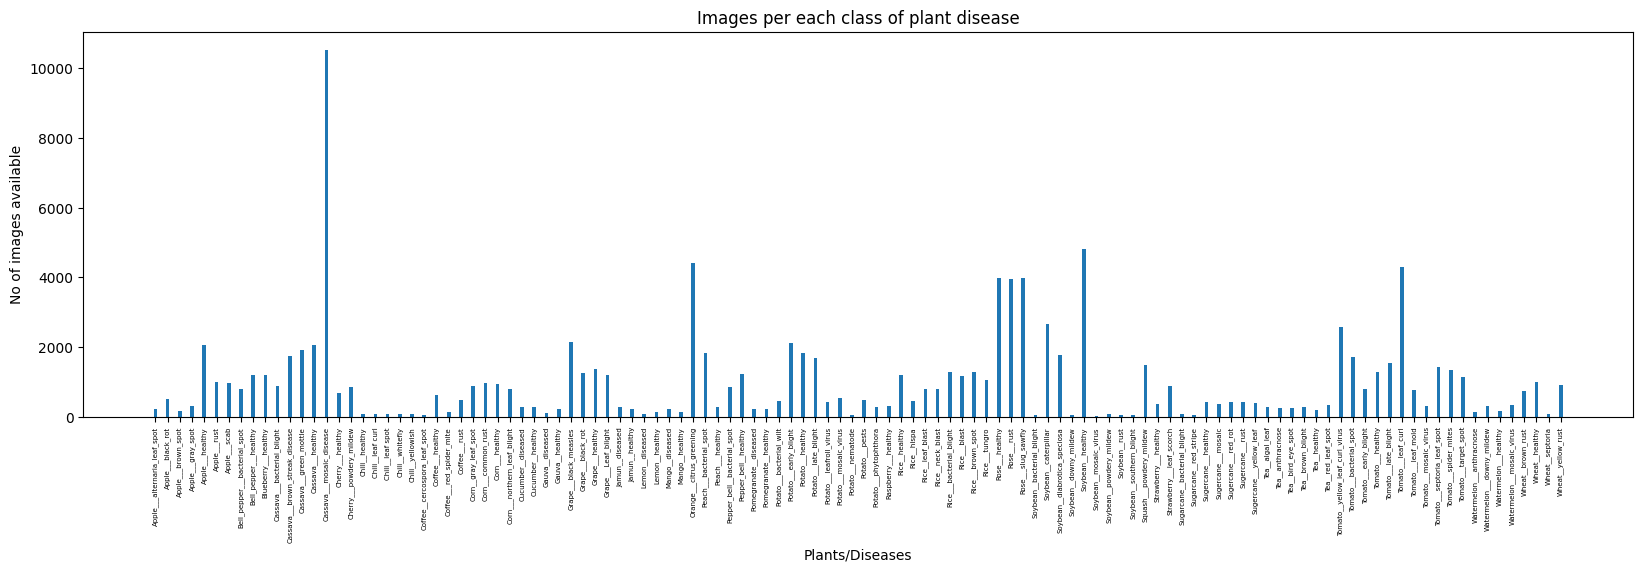

In [35]:
# plotting number of images available for each disease
index = [n for n in range(116)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [36]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 113804 images for training


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch Version: 2.8.0+cu128
CUDA Version: 12.8
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


# 🍳 Data Preparation for training 🍳

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Loading data...")
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f"Found {len(class_names)} classes.")
assert len(class_names) == NUM_CLASSES, "Number of classes in data does not match NUM_CLASSES config."
print(f"Dataset sizes: Train={dataset_sizes['train']}, Val={dataset_sizes['val']}")

Loading data...
Found 116 classes.
Dataset sizes: Train=113803, Val=14162


*A "Good and Complex" Custom CNN Model Definition*

In [39]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut path (to handle changes in dimension)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Add the output of the main path to the shortcut path
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Now, define the full network using these blocks
class ComplexCustomCNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=116):
        super(ComplexCustomCNN, self).__init__()
        self.in_channels = 64
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.linear(out)
        return out

# Instantiate the model
# The list [2, 2, 2, 2] defines how many residual blocks are in each layer.
# This creates a network with a structure similar to ResNet18.
model = ComplexCustomCNN(ResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES)
model = model.to(device)

In [40]:
print(f"--- Model Summary for {MODEL_NAME} ---")
# The input_size is (channels, height, width) for a single image
summary(model, input_size=(3, 224, 224))
print("-" * 70)

--- Model Summary for CustomCNN_v1 ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
              ReLU-9         [-1, 64, 224, 224]               0
    ResidualBlock-10         [-1, 64, 224, 224]               0
           Conv2d-11         [-1, 64, 224, 224]          36,864
      BatchNorm2d-12         [-1, 64, 224, 224]             128
             ReLU-13         [-1, 64, 224, 224]               0


# 🏗️ Modelling 🏗️

It is advisable to use GPU instead of CPU when dealing with images dataset because CPUs are generalized for general purpose and GPUs are optimized for training deep learning models as they can process multiple computations simultaneously. They have a large number of cores, which allows for better computation of multiple parallel processes. Additionally, computations in deep learning need to handle huge amounts of data — this makes a GPU’s memory bandwidth most suitable.
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required

In [ ]:
criterion = nn.CrossEntropyLoss()

# ✨ SWITCH TO AdamW ✨
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Add weight_decay here

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=len(dataloaders['train']))

In [42]:
LOAD_CHECKPOINT = True # Set to True to resume, False to start from scratch
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.pth')

start_epoch = 0

if LOAD_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found at {CHECKPOINT_PATH}. Loading...")
    # Load the checkpoint. The map_location argument ensures that the model is loaded to the correct device.
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 # We start from the next epoch
    
    print(f"Resuming training from Epoch {start_epoch}")
    # If you are increasing the total number of epochs, you need to re-initialize the scheduler
    # with the new total number of epochs, but starting from the loaded state.
    # This is an advanced case, for now, we assume you are completing the original run.
else:
    print("No checkpoint found or LOAD_CHECKPOINT is False. Starting training from scratch.")

Checkpoint found at ./models/CustomCNN_v1\best_model.pth. Loading...
Resuming training from Epoch 12


In [43]:


def train_model(model, criterion, optimizer, scheduler, num_epochs=10, start_epoch=0):
    since = time.time()
    
    best_model_wts = model.state_dict()
    
    # Load the best accuracy from the checkpoint if it exists, otherwise start at 0.
    best_acc = 0.0
    # Use the global variables defined in Cell 4.5 to check for the checkpoint
    if LOAD_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        # Use .get() for safety in case the key doesn't exist in an old checkpoint
        best_acc = checkpoint.get('accuracy', 0.0) 
        print(f"Loaded best accuracy from previous run: {best_acc:.4f}")

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # The loop now correctly starts from the `start_epoch`
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for a nice progress bar
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} phase"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
 
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                save_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': epoch_loss,
                    'accuracy': best_acc
                }, save_path)
                print(f"New best model saved to {save_path} with accuracy: {best_acc:.4f}")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# --- Start the training process ---
# This part calls the training function defined in a previous cell.
model, history = train_model(model, criterion, optimizer, scheduler, 
                             num_epochs=NUM_EPOCHS, 
                             start_epoch=start_epoch)



Loaded best accuracy from previous run: 0.8919
Epoch 13/15
----------


train phase:   2%|▏         | 107/7113 [00:50<54:35,  2.14it/s] 


KeyboardInterrupt: 

In [ ]:

# --- UNIFIED PLOTTING FUNCTION ---
def plot_training_history(history, model_name):
    """
    Plots the training and validation accuracy and loss side-by-side.
    Also annotates the best validation accuracy.
    """
    train_acc = [acc for acc in history['train_acc']]
    val_acc = [acc for acc in history['val_acc']]
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Training History for {model_name}', fontsize=16)

    ax1.plot(train_acc, label='Train Accuracy', marker='o', linestyle='-')
    ax1.plot(val_acc, label='Validation Accuracy', marker='o', linestyle='-')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='best')
    ax1.grid(True)

    if val_acc:
        best_epoch = val_acc.index(max(val_acc))
        best_val_acc = max(val_acc)
        ax1.axvline(x=best_epoch, color='r', linestyle='--', linewidth=1)
        ax1.annotate(f'Best Val Acc: {best_val_acc:.4f}\nat Epoch {best_epoch+1}',
                     xy=(best_epoch, best_val_acc),
                     xytext=(best_epoch, best_val_acc - 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     ha='center')

    ax2.plot(train_loss, label='Train Loss', marker='o', linestyle='-')
    ax2.plot(val_loss, label='Validation Loss', marker='o', linestyle='-')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='best')
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- IMPROVED LEARNING RATE PLOTTER ---
def plot_learning_rate_schedule(history):
    """
    Plots the learning rate used during training.
    """
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    
    if lrs.size > 0:
        plt.figure(figsize=(10, 5))
        plt.plot(lrs)
        plt.xlabel('Batch no.')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate vs. Batch Number (OneCycleLR Schedule)')
        plt.grid(True)
        plt.show()
    else:
        print("No learning rate history found to plot.")



--- Generating Training Plots ---


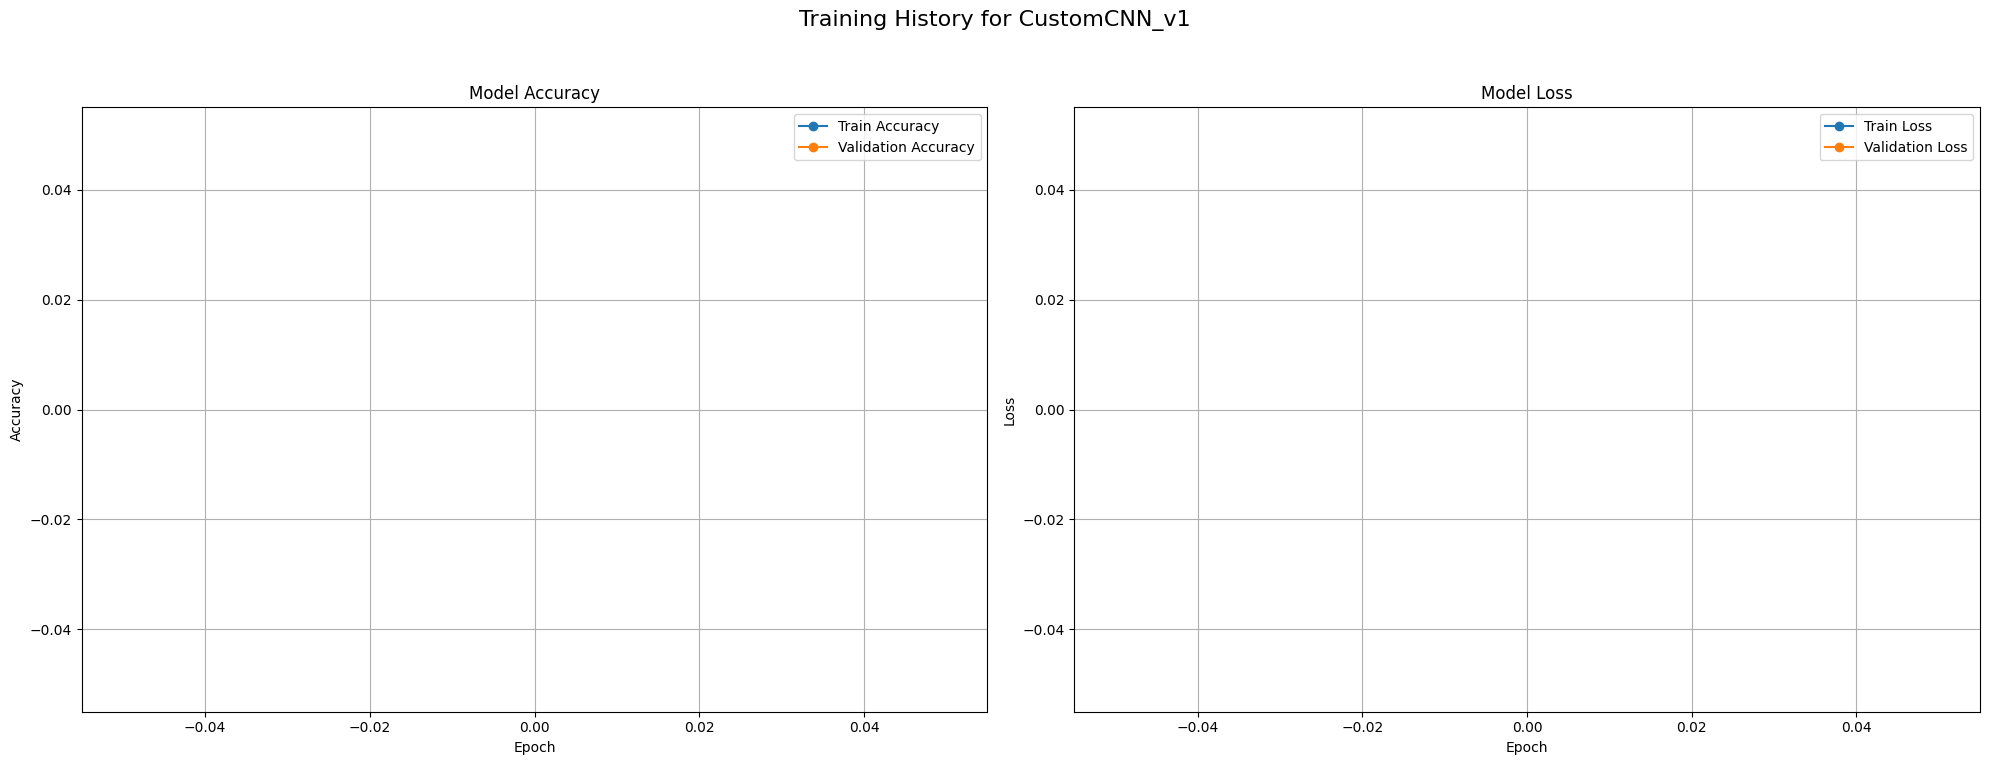

AttributeError: 'str' object has no attribute 'get'

In [ ]:
print("\n--- Generating Training Plots ---")
plot_training_history(history, MODEL_NAME)
plot_learning_rate_schedule(history)